In [1]:
import numpy as np
from keras.utils import to_categorical

import glob
import cv2 
import math

from scipy.linalg import svd
from numpy import linalg as LA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os

%matplotlib inline

Using TensorFlow backend.


In [32]:
dim_img = np.array([50,50])



In [33]:
path = glob.glob("D:\ML Dataset\Face_Extracted_Aug/*.png")

# Rading dataset
X = []

    
for img in path:
    if "RGB" in img:
        n = cv2.imread(img)
        gray = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray,(dim_img[0],dim_img[1]))
        X.append(gray)





In [34]:
# Convert List dataset into array
X = np.array(X)

In [35]:
ExpressionArray = ["Anger","Disgust","Fear","Happy","Neutral","Surprise","Sad"]

Y = np.zeros((len(X)))
i=0
for img in path:
    if "RGB" in img:
        if "Anger" in img: 
            Y[i]  = 0
        elif "Disgust" in img: 
            Y[i]  = 1 
        elif "Fear" in img: 
            Y[i]  = 2 
        elif "Happy" in img: 
            Y[i]  = 3 
        elif "Neutral" in img: 
            Y[i]  = 4 
        elif "Surprise" in img: 
            Y[i]  = 5 
        else:
            Y[i]  = 6 
            
        i = i+1


In [36]:
len(X),len(Y)

(4056, 4056)

In [37]:


# # Reading Annotation file of Emotion
# Emotion = pd.read_csv('D:/ML Dataset/Annotations/Train_Expression.txt', sep=" ", header=None)
# Emotion.columns = ["filename", "Emotion"]


In [38]:
Y_one_hot = to_categorical(Y)

In [39]:
Y_one_hot,Y

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]], dtype=float32),
 array([0., 0., 0., ..., 5., 5., 5.]))

In [40]:
X = X.astype('float32')
X = X / 255

X = X.reshape(-1,dim_img[0],dim_img[1], 1)
X.shape

(4056, 50, 50, 1)

In [41]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_Y,test_Y = train_test_split(X, Y_one_hot, test_size=0.1, random_state=13)
train_X.shape,test_X.shape,train_Y.shape,test_Y.shape

((3650, 50, 50, 1), (406, 50, 50, 1), (3650, 7), (406, 7))

In [42]:
train_X,valid_X,train_Y,valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=13)
train_X.shape,valid_X.shape,train_Y.shape,valid_Y.shape

((2920, 50, 50, 1), (730, 50, 50, 1), (2920, 7), (730, 7))

In [43]:
# data = pd.read_csv('D:/ML Dataset/Annotations/Train_Roll_Number.txt', sep=" ", header=None)
# data1 = pd.read_csv('D:/ML Dataset/Annotations/Train_RGB_Sketch.txt', sep=" ", header=None)
# data2 = pd.read_csv('D:/ML Dataset/Annotations/Train_Gender.txt', sep=" ", header=None)
# data3 = pd.read_csv('D:/ML Dataset/Annotations/Train_Expression.txt', sep=" ", header=None)


In [44]:

# data.columns = ["filename", "subject"]
# data1.columns = ["filename", "sketch"]
# data2.columns = ["filename", "gender"]
# data3.columns = ["filename", "expression"]


# **Model the Data**

In [45]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [46]:
batch_size = 100
epochs = 60
num_classes = 7

In [47]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='valid',input_shape=(dim_img[0],dim_img[1],1)))
model.add(MaxPooling2D((2, 2),padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='linear',padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='linear',padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='valid'))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(2048, activation='linear'))
model.add(Dropout(0.3))

model.add(Dense(1000, activation='linear'))
model.add(Dropout(0.3))

model.add(Dense(250, activation='linear'))
model.add(Dropout(0.3))

model.add(Dense(80, activation='linear'))          
model.add(Dropout(0.3))

model.add(Dense(15, activation='linear'))          
model.add(Dropout(0.3))


model.add(Dense(num_classes, activation='softmax'))

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 9, 128)         73856     
__________

In [49]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [50]:
train_dropout = model.fit(train_X, train_Y, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_Y))

Train on 2920 samples, validate on 730 samples
Epoch 1/60
2920/2920 [==============================] - 20s 7ms/step - loss: 2.5495 - acc: 0.1521 - val_loss: 2.0150 - val_acc: 0.1507
Epoch 2/60
2920/2920 [==============================] - 19s 6ms/step - loss: 1.9623 - acc: 0.1695 - val_loss: 1.8930 - val_acc: 0.2205
Epoch 3/60
2920/2920 [==============================] - 19s 7ms/step - loss: 1.9087 - acc: 0.2038 - val_loss: 1.8384 - val_acc: 0.2616
Epoch 4/60
2920/2920 [==============================] - 19s 7ms/step - loss: 1.8621 - acc: 0.2394 - val_loss: 1.7835 - val_acc: 0.2507
Epoch 5/60
2920/2920 [==============================] - 24s 8ms/step - loss: 1.8417 - acc: 0.2503 - val_loss: 1.7308 - val_acc: 0.3082
Epoch 6/60
2920/2920 [==============================] - 22s 8ms/step - loss: 1.7929 - acc: 0.2726 - val_loss: 1.6716 - val_acc: 0.3658
Epoch 7/60
2920/2920 [==============================] - 19s 6ms/step - loss: 1.7381 - acc: 0.3041 - val_loss: 1.6311 - val_acc: 0.3890
Epoch 8/

In [51]:
model.save("CNN_Emotion_model.h5")

In [52]:
test_eval = model.evaluate(test_X, test_Y, verbose=1)

406/406 [==============================] - 1s 2ms/step


In [53]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.5438433248421242
Test accuracy: 0.8472906392196129


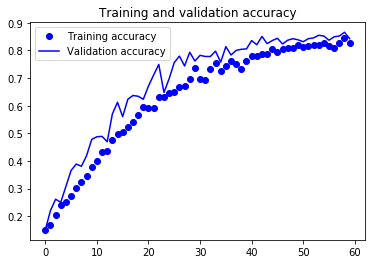

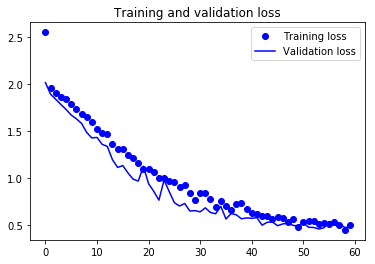

In [54]:
accuracy = train_dropout.history['acc']
val_accuracy = train_dropout.history['val_acc']
loss = train_dropout.history['loss']
val_loss = train_dropout.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [55]:
predicted_classes = model.predict(test_X)

In [56]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

In [57]:
test_Y_Pre = np.argmax(np.round(test_Y),axis=1)

In [58]:
predicted_classes.shape, test_Y_Pre.shape

((406,), (406,))

Found 335 correct labels


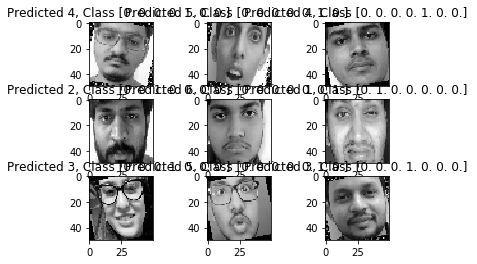

In [59]:
correct = np.where(predicted_classes==test_Y_Pre)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(dim_img[0],dim_img[1]), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {} ".format(predicted_classes[correct], test_Y[correct]))

Found 71 incorrect labels


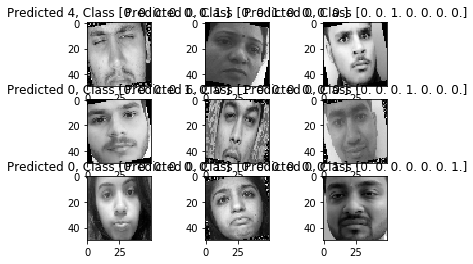

In [60]:
incorrect = np.where(predicted_classes!=test_Y_Pre)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(dim_img[0],dim_img[1]), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))

In [61]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y_Pre, predicted_classes, target_names=target_names))
 

              precision    recall  f1-score   support

     Class 0       0.60      0.87      0.71        54
     Class 1       0.77      0.94      0.85        51
     Class 2       0.88      0.70      0.78        61
     Class 3       0.95      0.76      0.85        51
     Class 4       0.78      0.94      0.85        50
     Class 5       0.95      0.90      0.93        63
     Class 6       0.96      0.71      0.82        76

   micro avg       0.83      0.83      0.83       406
   macro avg       0.84      0.83      0.83       406
weighted avg       0.85      0.83      0.83       406

